In [1]:
!pip install transformers==3.1.0
!pip install pyblaze

     |████████████████████████████████| 884 kB 7.7 MB/s 
     |████████████████████████████████| 895 kB 49.8 MB/s 
     |████████████████████████████████| 3.0 MB 48.1 MB/s 
     |████████████████████████████████| 1.2 MB 55.3 MB/s 
     |████████████████████████████████| 66 kB 3.8 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [2]:
from transformers import pipeline

In [3]:
import pandas as pd
from pathlib import Path
import time

In [ ]:
data_path = Path('/content/drive/Shareddrives/taxi_trends/Data/twitter data/') # colab
# data_path = Path('') # local

### Model import

In [4]:
global classifier, topic_labels, sentiment_labels

In [5]:
# Takes time, run only once
# Read in the classifier
classifier = pipeline("zero-shot-classification", device=0) # to utilize GPU

Downloading:   0%|          | 0.00/908 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/bart-large-mnli were not used when initializing BartForSequenceClassification: ['model.encoder.version', 'model.decoder.version']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Example

In [51]:
seq = ['we just went caroling and had a lot of fun', 
       'rudolph is near our neighborhood', 
       'dissapointed that santa was not here', 
       'looking into my stocking for presents', 
       'there was an incident in the freeway, caution', 
       'drew barrymore is in our city!']

labels = ['christmas', 'celebrity', 'traffic']
sent_labels = ['happy', 'sad', 'excited']
topic = classifier(seq, labels)
sent = classifier(seq, sent_labels)

In [52]:
vals = [zip(out['labels'], out['scores']) for out in sent]
tab = []
for i,a in enumerate(vals):
  for b in a:
    tab.append([seq[i], b[0], b[1]])
    print("{}: {:.0f}%".format(b[0], b[1]*100))

happy: 73%
excited: 27%
sad: 0%
excited: 60%
happy: 33%
sad: 7%
sad: 99%
excited: 1%
happy: 1%
excited: 68%
happy: 29%
sad: 3%
sad: 75%
excited: 19%
happy: 6%
excited: 75%
happy: 22%
sad: 3%


In [53]:
tab = pd.DataFrame(tab, columns = ['Seq', 'sentiment', 'confidence'])

In [54]:
tab.dtypes

Seq            object
sentiment      object
confidence    float64
dtype: object

In [55]:
sns.set()

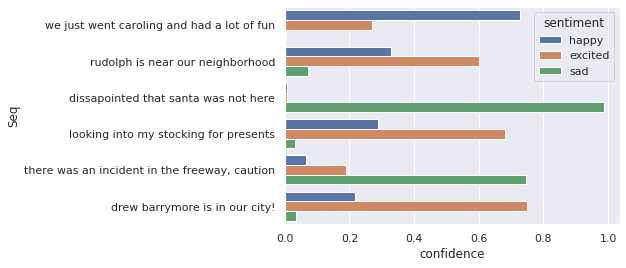

In [56]:
sns.barplot(x=tab.confidence, y=tab.Seq, orient='h', hue=tab.sentiment)

In [ ]:
conf_threshold = 0.3
topic_labels = ['holidays-celebration', 'thanksgiving', 'traffic-construction', 'concert-events', 'sports', 'politics']
sentiment_labels = ['happy', 'angry', 'sad', 'excited', 'neutral']

### With spark

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import DataFrame, SparkSession

In [ ]:
spark = SparkSession.builder.master("local[*]")\
        .appName("twitterprocessing")\
        .config("spark.driver.memory", "16g")\
        .getOrCreate()

In [ ]:
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, FloatType

customSchema = StructType([
  StructField("id", IntegerType(), True),
  StructField("timestamp_ms", FloatType(), True),
  StructField("coordinates", StringType(), True),
  StructField("text", StringType(), True),
  StructField("timestamp_dt", StringType(), True),
  StructField("tweet_date", StringType(), True),
  StructField("taxizone", StringType(), True)]
)

twitter_df = spark.read.csv((data_path / 'twitter_3mon_withzonecsv').as_posix(), header=True, schema=customSchema)

In [ ]:
twitter_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timestamp_ms: float (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- tweet_date: string (nullable = true)
 |-- taxizone: string (nullable = true)



In [ ]:
from pyspark.sql.functions import udf, col, pandas_udf

In [ ]:
sub = twitter_df.show()

+----+-------------+--------------------+--------------------+---------------+----------+--------------------+
|  id| timestamp_ms|         coordinates|                text|   timestamp_dt|tweet_date|            taxizone|
+----+-------------+--------------------+--------------------+---------------+----------+--------------------+
|null|1.54072436E12|{'type': 'Point',...|Flushing Avenue a...|20181028 110020|  20181028|             Maspeth|
|null|1.54072436E12|{'type': 'Point',...|Maybe u should ca...|20181028 110021|  20181028|TriBeCa/Civic Center|
|null|1.54072449E12|{'type': 'Point',...|Thank you to ever...|20181028 110032|  20181028|                null|
|null|1.54072449E12|{'type': 'Point',...|Two more photos f...|20181028 110050|  20181028|TriBeCa/Civic Center|
|null|1.54072449E12|{'type': 'Point',...|Elle's Everyday E...|20181028 110051|  20181028|                SoHo|
|null|1.54072449E12|{'type': 'Point',...|Car Conversations...|20181028 110052|  20181028|                SoHo|
|

In [ ]:
sc = spark.sparkContext

In [ ]:
broadcastClassifier = sc.broadcast(classifier)

In [ ]:
# !pip install cachetools
# @cached(cache={}) 
# def get_cached_object():
#     # this call is really slow therefore I am trying 
#     # to cache it with cachetools
#     return classifier

In [ ]:
@pandas_udf(StringType())
def get_topic(text):
  seq = list(text)
  classes = broadcastClassifier.value(seq, topic_labels)
  return pd.Series([out['labels'][0] for out in classes])
  # return text

@pandas_udf(StringType())
def get_sentiment(text):
  seq = list(text)
  classes = broadcastClassifier.value(seq, sentiment_labels)
  return pd.Series([out['labels'][0] for out in classes])
  # return text

In [ ]:
# Row wise UDF too slow
# classify = udf(lambda x: classifier(x, topic_labels))
# twitter_df_small = twitter_df_small.withColumn("topic", get_topic(col("text")))

# Pandas UDF
# Faced out of memory issue (java heap space error) with classifier being copied to worker nodes
# classifier object was set to be cached and broadcast
# twitter_df_small = twitter_df.limit(20)
# twitter_df_small.withColumn('topic', get_topic(col('text'))).collect()

In [ ]:
twitter_df = twitter_df.withColumn("topic", get_topic(col('text'))).withColumn("sentiment", get_sentiment(col('text')))

In [ ]:
twitter_df_proc = twitter_df.toPandas()

### With Pandas

In [ ]:
# Converting the initial Spark DF to pandas df and writing it to a file
# Already writter, read from the data folder
# twitter_df_pd = twitter_df.toPandas()
# twitter_df_pd.to_csv(data_path / 'twitter_3mon_withzonecsv_pd.csv')

In [ ]:
twitter_df_pd = pd.read_csv(data_path / 'twitter_3mon_withzonecsv_pd.csv')

In [ ]:
# Filtering out bad text records
twitter_df_pd_fil = twitter_df_pd[pd.isnull(twitter_df_pd['text']) == False]

In [ ]:
twitter_df_pd_fil.shape

(1240452, 8)

In [ ]:
# Sending full sequence to the classifier
# Will face GPU out of memory error

# start = time.time()
# topics = classifier(list(twitter_df_pd_fil['text'].head(200)), topic_labels)
# print(time.time()-start)

In [ ]:
def classify(x, labels, threshold = 0.4):
  out = classifier(x, candidate_labels=labels)
  return 'other' if out['scores'][0] < threshold else out['labels'][0]

In [ ]:
# Test
classify('how was the turkey', topic_labels, conf_threshold)

'thanksgiving'

In [ ]:
from tqdm.auto import tqdm
import time

In [ ]:
# 100 record takes ~10 mins
# @ Ishan - use this method to get topics for the halloween week (should be ~70k records, would take around 90 mins)
# Refer to the tqdm method below, if tqdm takes a similar time, you can use it to get a better idea of the progress/time-taken
twitter_df_pd_tweek = twitter_df_pd_fil[(twitter_df_pd_fil['tweet_date'] >= '20181119') & (twitter_df_pd_fil['tweet_date'] <= '20181126')]
print(twitter_df_pd_tweek.shape)
# out = twitter_df_pd_tweek.text.apply(lambda x: classify(x, conf_threshold))

twitter_df_pd_hweek = twitter_df_pd_fil[(twitter_df_pd_fil['tweet_date'] >= '20181028') & (twitter_df_pd_fil['tweet_date'] <= '20181103')]
twitter_df_pd_hweek.shape

# # Using tqdm instead of pandas apply to track progress
# start = time.time()
# topics = []
# sent = []
# for seq in tqdm(twitter_df_pd_tweek.text.to_list()):
#   topics.append(classify(seq, topic_labels, conf_threshold))
#   sent.append(classify(seq, sentiment_labels, conf_threshold))
# print(f'Time: {time.time()-start}')

(82464, 8)


(81682, 8)

In [ ]:
# Using tqdm instead of pandas apply to track progress
start = time.time()
topics = []
sent = []
for seq in tqdm(twitter_df_pd_tweek.text.to_list()):
  topics.append(classify(seq, topic_labels, conf_threshold))
  sent.append(classify(seq, sentiment_labels, conf_threshold))
print(f'Time: {time.time()-start}')

  0%|          | 0/82464 [00:00<?, ?it/s]

Time: 7733.905910015106


In [ ]:
twitter_df_pd_tweek.head

<bound method NDFrame.head of          Unnamed: 0  id  ...                 topic sentiment
815891       815891 NaN  ...        concert-events   excited
815892       815892 NaN  ...                 other   neutral
815893       815893 NaN  ...  holidays-celebration   excited
815894       815894 NaN  ...        concert-events   excited
815895       815895 NaN  ...  traffic-construction   excited
...             ...  ..  ...                   ...       ...
1001230     1001230 NaN  ...  traffic-construction   excited
1001231     1001231 NaN  ...  traffic-construction   excited
1001236     1001236 NaN  ...  holidays-celebration     happy
1001239     1001239 NaN  ...  traffic-construction   neutral
1001246     1001246 NaN  ...                 other       sad

[82464 rows x 10 columns]>

In [ ]:
twitter_df_pd_tweek['topic'] = topics
twitter_df_pd_tweek['sentiment'] = sent

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
twitter_df_pd_tweek.topic.value_counts()

other                   24392
holidays-celebration    22492
traffic-construction    19261
concert-events           8074
sports                   6098
politics                 2035
halloween                 112
Name: topic, dtype: int64

In [ ]:
pd.options.display.max_colwidth = None
twitter_df_pd_tweek[twitter_df_pd_tweek['topic'] == 'halloween']['text'].head(20)

816809                                                                  #darkangel #dusk #newyork #fall #shades @ Central Park https://t.co/xaXQHvKgGX
816937                                                                            #ibeenhadskills🔥✍🏾 #RunForYaLife #BARbarian… https://t.co/jvjN15AMKe
822327                                         #nightphotography @ #centralpark #fallnights #fotografianocturna @ Central Park https://t.co/eGvIWDHQTC
822562                    anthropologienyc #anthropologiewindows #windowdressing #storedisplay #justwalkingby #artforcommerce… https://t.co/uLN2T9iYML
823066    Staying on the pumpkin theme, I didn't realise I was going to be one when I accepted that modeling job in New York!… https://t.co/aLO72wlxhH
823631    Morning, Phoenixes!! Hitting y’all with the #TBT today, still can’t get enough of this year’s Halloween costume and… https://t.co/bP3t5NfXgR
824615                                                                                     Spo

In [ ]:
# twitter_df_pd_tweek.to_csv(data_path / 'thanksgiving_topic_results.csv')
twitter_df_pd_hweek.to_csv(data_path / 'halloween_topic_results.csv')

In [ ]:
# Sending pandas series to a function
# def classify(sequences, classifier, labels):
#   classes = classifier(sequences, labels)
#   return pd.Series([out['labels'][0] for out in classes])

# topics = classify(twitter_df_pd_fil.text.head(1000).to_list(), classifier, topic_labels)
# twitter_df_pd_fil['topic'] = classify(twitter_df_pd_fil.text.to_list(), classifier, topic_labels)

### Tweet topic analysis

In [ ]:
import seaborn as sns
import pandas as pd
from pathlib import Path

data_path = Path('/content/drive/Shareddrives/taxi_trends/Data/twitter data/') # colab
# data_path = Path('') # local

In [ ]:
sns.set_palette('deep')
sns.set()

#### Halloween Week

In [ ]:
hweek = pd.read_csv(data_path / 'halloween_topic_results.csv')

In [ ]:
topic_sentiment_dist = hweek[['topic', 'sentiment']].value_counts().to_frame('count')

In [96]:
pal = list(sns.color_palette('deep').as_hex())

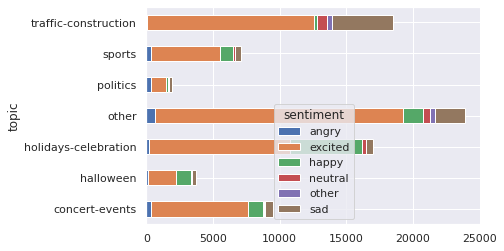

In [97]:
df_pivot = pd.pivot_table(topic_sentiment_dist, index='topic', columns='sentiment', values='count', aggfunc='sum')
df_pivot.plot.barh(stacked=True, color=pal)

In [ ]:
hal_zones = hweek[hweek['topic'] == 'halloween']['taxizone'].value_counts().nlargest(10).to_frame('count')

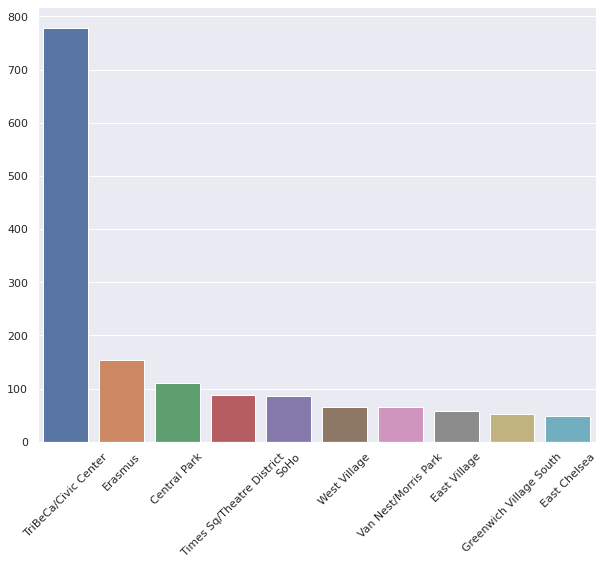

In [98]:
plt.figure(figsize = (10,8))
plt.xticks(rotation=45)
sns.barplot(x=hal_zones.index, y=hal_zones['count'].tolist())

In [73]:
hweek['taxizone'].value_counts().nlargest(10).to_frame('count')

,count
TriBeCa/Civic Center,11964
SoHo,2016
Central Park,1797
Times Sq/Theatre District,1681
Erasmus,1650
Penn Station/Madison Sq West,1193
Sunset Park West,1022
Clinton East,983
Midtown Center,940
East Chelsea,816


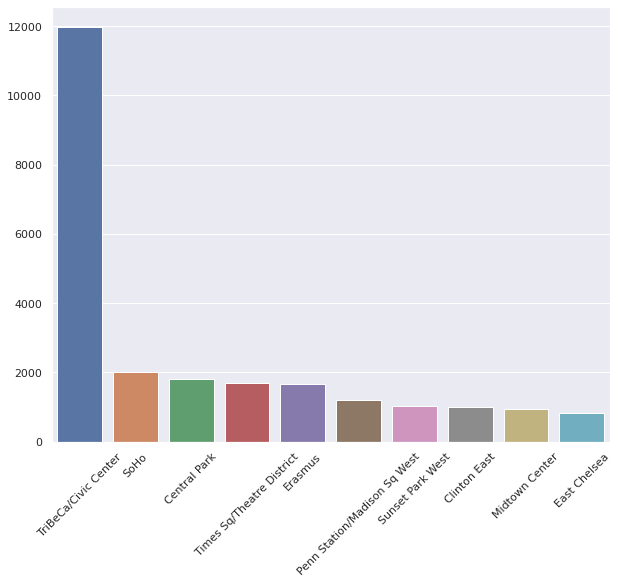

In [77]:
overall_zones = hweek['taxizone'].value_counts().nlargest(10).to_frame('count')
plt.figure(figsize = (10,8))
plt.xticks(rotation=45)
sns.barplot(x=overall_zones.index, y=overall_zones['count'].tolist())

In [81]:
hweek[(hweek['topic'] == 'halloween') & (hweek['taxizone'] == 'TriBeCa/Civic Center')].shape[0]/hweek[(hweek['topic'] == 'halloween')].shape[0]

0.20957761635727737

In [82]:
hweek[(hweek['taxizone'] == 'TriBeCa/Civic Center')].shape[0]/hweek.shape[0]

0.1464704586077716

In [119]:
pd.options.display.max_colwidth = None
hweek[(hweek['topic'] == 'halloween') & (hweek['taxizone'] == 'TriBeCa/Civic Center') & (hweek['text'].str.contains('duane', case=False))].text.head(20)

35938    Halloween celebrations on Duane Street ! Simply wild ❤️ #halloween #celebrations #tribeca @ Tribeca https://t.co/tkLP0k18bF
Name: text, dtype: object

#### Thanksgiving Week

In [160]:
tweek = pd.read_csv(data_path / 'thanksgiving_topic_results.csv')

In [163]:
tweek.taxizone.value_counts().nlargest(10)

TriBeCa/Civic Center            11710
SoHo                             2048
Times Sq/Theatre District        1583
Central Park                     1504
Erasmus                          1468
Penn Station/Madison Sq West     1427
Midtown Center                   1197
Clinton East                     1049
Sunset Park West                 1020
Van Nest/Morris Park              884
Name: taxizone, dtype: int64

In [202]:
parade_tweets = tweek[(tweek['text'].str.contains('macy', case=False)) | (tweek['text'].str.contains('macy', case=False))]

In [198]:
parade_zones = parade_tweets.taxizone.value_counts().nlargest(10).to_frame('count')

In [199]:
ratio = tweek[tweek['taxizone'].isin(parade_zones.index.tolist())].taxizone.value_counts().to_frame('count').merge(parade_zones, how='outer', left_index=True, right_index=True)

In [200]:
ratio['ratio'] = ratio['count_y']/ratio['count_x']

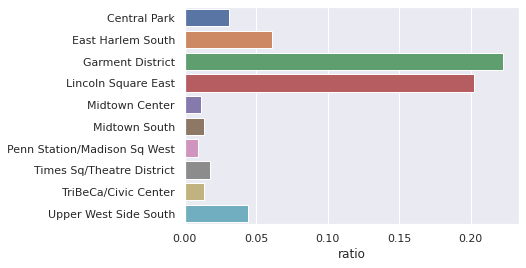

In [201]:
sns.barplot(y=ratio.index, x=ratio.ratio)

In [204]:
parade_agg = parade_tweets[['topic', 'sentiment']].value_counts().to_frame('count')

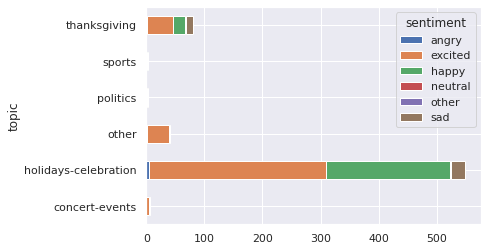

In [205]:
df_pivot = pd.pivot_table(parade_agg, index='topic', columns='sentiment', values='count', aggfunc='sum')
df_pivot.plot.barh(stacked=True, color=pal)

#### Christmas Week

In [120]:
cweek = pd.read_csv(data_path / 'christmas_topic_results.csv')

In [125]:
zone = 'Times Sq/Theatre District'

In [143]:
# Tribeca check
cweek[(cweek['taxizone'] == 'TriBeCa/Civic Center')].shape[0]/cweek.shape[0]

0.13963877105026354

In [129]:
cweek[cweek['taxizone'] == zone].topic.value_counts()

holidays-celebration    860
concert-events          341
other                   246
traffic-construction    125
sports                   68
christmas                15
politics                 14
Name: topic, dtype: int64

In [141]:
cweek[(cweek['text'].str.contains('new year', case=False)) & (cweek['text'].str.contains('times square', case=False))].head(20)

,Unnamed: 0,Unnamed: 0.1,id,timestamp_ms,coordinates,text,timestamp_dt,tweet_date,taxizone,topic,sentiment
119,1403715,1403715,NaN,1.546197e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","Live from Times Square: it’s almost New Year and it’s time to leave the past in the past. Forgive situations, peopl… https://t.co/I16P1G7ACR",20181230 191702,20181230,Times Sq/Theatre District,holidays-celebration,excited
921,1404999,1404999,NaN,1.546173e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}",Friday afternoon impulse.. Runcton Holme ✈ New York. Experiencing New Years eve in Times Square will be different!!… https://t.co/uBGNal1hEy,20181230 123532,20181230,Times Sq/Theatre District,holidays-celebration,excited
5005,1412160,1412160,NaN,1.546192e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","The Times Square Ball getting prepped for New Year’s Eve #NYC @ Times Square, New York City https://t.co/wvITzYWP8r",20181230 174954,20181230,Times Sq/Theatre District,holidays-celebration,excited
5712,1413286,1413286,NaN,1.546226e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","Setting up before the the New year event @ Times Square, New York City https://t.co/RvcLErw0UP",20181231 031048,20181231,Times Sq/Theatre District,holidays-celebration,excited
6041,1413765,1413765,NaN,1.546228e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","Everything is ready for tomorrow night's New Year's Rockin' Eve 🎉 Where is Ryan Seacrest? 💖🎆 @ Times Square, New Yo… https://t.co/KG5ztg22Jc",20181231 034715,20181231,Times Sq/Theatre District,holidays-celebration,excited
6776,1414977,1414977,NaN,1.546211e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","happy New Year’s eve eve 🍎 @ Times Square, New York City https://t.co/x5XzYmWgKN",20181230 231029,20181230,Times Sq/Theatre District,holidays-celebration,happy
7329,1415777,1415777,NaN,1.546230e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","Trabajando para ti:: TELEMUNDO 47 NEW YORK, HAPPY NEW YEAR TO ALL. #telemundo47 @ Times Square, New York City https://t.co/tdBzIoRf8h",20181231 041621,20181231,Times Sq/Theatre District,holidays-celebration,happy
8609,1418052,1418052,NaN,1.546202e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","coming down for new year 2019in NY 🎆 @ Times Square, New York City https://t.co/20GBiAQ7A7",20181230 204129,20181230,Times Sq/Theatre District,holidays-celebration,excited
19550,1462924,1462924,NaN,1.545699e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","Merry Christmas and a happy New Year to everyone hope you all have an amazing day @ Times Square, New York City https://t.co/FIgvrgLcb1",20181225 004749,20181225,Times Sq/Theatre District,holidays-celebration,happy
23063,1468911,1468911,NaN,1.546032e+12,"{'type': 'Point', 'coordinates': [-73.98591185, 40.7577936]}","As a tradition, I always come up to write my New Year wishes on the confetti that drops in Times Square at midnight… https://t.co/NzlwAc9YaK",20181228 211236,20181228,Times Sq/Theatre District,holidays-celebration,excited


In [ ]:
cweek[cweek['topic'] == 'traffic-construction']['']

#### Row-wise classification

In [ ]:
twitter_df_pd_fil['sentiment'] = twitter_df_pd_fil.text.apply(lambda x: classifier(x, candidate_labels=sentiment_labels)['labels'][0])

In [ ]:
twitter_df_pd_fil.to_csv((data_path / "twitter_path" / "twitter_out_final.csv").as_posix())

### Swifter

In [ ]:
# !pip install swifter

# import swifter
# start = time.time()
# twitter_df_pd_fil['text'].head(10000).swifter.apply(lambda x: classifier(x, topic_labels)['labels'][0])
# print(time.time()-start)

### Pandarallel

In [ ]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.5.4-py3-none-any.whl size=18688 sha256=0b9fc12ef4f45c8684076bc1df86a7af8280bed04d15a65b368ecc4d623c5548
  Stored in directory: /root/.cache/pip/wheels/71/de/ad/759faf4fea1e9b0fd935da28847aa3ca2eef14a888c2dc4952
Successfully built pandarallel


In [ ]:
from pandarallel import pandarallel

In [ ]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
from torch.multiprocessing import Process, Pool, set_start_method

In [ ]:
set_start_method('spawn', force=True)

In [ ]:
topics = twitter_df_pd_fil['text'].head(10000).parallel_apply(classifier, candidate_labels=topic_labels, )

### Multi-processing

In [ ]:
from multiprocessing import Process, Pool
import numpy as np

def classify(args):
  seq = list(args[0])
  classes = classifier(seq, args[1])
  return input_img

multi_pool = Pool(processes=4)
predictions = multi_pool.map(classify, [twitter_df_pd_fil['text'].head(10000), topic_labels])
multi_pool.close() 
multi_pool.join()

In [ ]:
import multiprocessing
import sys

def f(name):
    print('hello', name)
    sys.stdout.flush()

for i in range(5):
  p = multiprocessing.Process(target=f, args=(i,))
  p.start()

In [ ]:
#!pip install pyblaze

In [ ]:
import pyblaze.multiprocessing as xmp

In [ ]:
classfunc = xmp.Vectorizer(classifier, num_workers=4)

In [ ]:
start = time.time()
classfunc.process(twitter_df_pd_fil.text.head(10000), topic_labels).compute()
print(time.time()-start)

### Dask

In [ ]:
!pip install dask[dataframe] --upgrade

     |████████████████████████████████| 132 kB 7.6 MB/s 


In [ ]:
import dask.dataframe as dd

In [ ]:
topics = dd.from_pandas(twitter_df_pd_fil.text.head(10000), npartitions=8).apply(classifier, candidate_labels=topic_labels, meta=(str)).compute()

In [ ]:
twitter_df_pd_fil.text.head(10000).apply(lambda x: classifier(x, candidate_labels=topic_labels)['labels'][0])

KeyboardInterrupt: ignored